In [15]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import lsq_linear   
from tqdm import trange
from importlib import reload

import utils.policies as polc
import utils.experiment_utils as expt
import utils.misc_utils as mutil

reload(polc)
reload(expt)
reload(mutil);

## Simulation Parameters

In [34]:
# simulation lengths
T_horizon = None # time horizon (to be set later)
T_horizon_list = 2000*np.arange(1,11)
N_runs    = 5 # number of simulations

# noise and arrival rates
arrival_rate   = 4  # lambda
noise_variance = 0.1 # sigma^2

# algorithm parameters
def random_uniform(size = []):
    return 2*np.random.uniform(size = size)-1
beta  = 8*noise_variance # exploration tuner (beta > 4 sigma^2)
nu    = None # backlog-cost tradeoff tuner (T^{1/3}) (to be set later)
delta = None # exploration tuner (T^{(-2 sigma^2)/(beta - 2 sigma^2)}) (to be set later)
noise_distribution = random_uniform # np.random.standard_normal

# topology
N_nodes          = 9
source_node      = 0
destination_node = 8
edges_list       = [[0,1], [0,4], [0,2], [1,3], [1,4], [2,5], [3,6], [6,4], [4,6], [4,7], [5,4], [5,7], [6,8], [4,8], [7,8]]
node_edge_adjacency = mutil.prepare_adjacency(edges_list, N_nodes)

# edge properties
edge_capacities = np.array([4,2,2,2,2,2,2,1,1,1,1,1,2,5,2]) # max-flow = 8
true_edge_costs = np.array([2,5,1,1,2,1,1,1,1,1,1,3,3,1,1])/10

# pack parameters
simulation_params = mutil.SimulationParameters(node_edge_adjacency, 
                 true_edge_costs, edge_capacities, 
                 source_node, destination_node, 
                 noise_variance, noise_distribution,
                 arrival_rate, 
                 N_runs, T_horizon, 
                 beta, delta, nu)

# visualize topology
mutil.visualize_network(edges_list, N_nodes)

## Static Policy

In [45]:
arrival_rate = 1
stat_edge_rates = polc.get_static_policy(node_edge_adjacency, source_node, destination_node, true_edge_costs, edge_capacities, arrival_rate)

total_stat_cost_per_time = stat_edge_rates@true_edge_costs
stat_costs = T_horizon_list*total_stat_cost_per_time

In [46]:
total_stat_cost_per_time

0.4

## DPOP Policy

In [5]:
np.random.seed(13)

tran_cost_till_T_dpop = np.zeros(T_horizon_list.shape)
tran_non_null_cost_till_T_dpop = np.zeros(T_horizon_list.shape)
backlog_cost_at_T_dpop = np.zeros(T_horizon_list.shape)
for ii in trange(T_horizon_list.shape[0]):
    T_horizon_value             = T_horizon_list[ii]
    simulation_params.T_horizon = T_horizon_value
    simulation_params.nu        = T_horizon_value**(1/3)   
    simulation_params.delta     = T_horizon_value**(-2*noise_variance/(beta-2*noise_variance))

    queueing_network = expt.run_horizon_experiment(simulation_params, 'dpop')
    tran_cost_till_tt, tran_non_null_cost_till_tt, _, _, backlog_cost_at_tt, _ = expt.calculate_costs(queueing_network)
    
    tran_cost_till_T_dpop[ii] = tran_cost_till_tt[-1]
    tran_non_null_cost_till_T_dpop[ii] = tran_non_null_cost_till_tt[-1]
    backlog_cost_at_T_dpop[ii] = backlog_cost_at_tt[-1]

dpop_costs = tran_cost_till_T_dpop + backlog_cost_at_T_dpop
dpop_non_null_costs = tran_non_null_cost_till_T_dpop + backlog_cost_at_T_dpop

100%|██████████| 10/10 [01:23<00:00,  8.37s/it]


In [6]:
print('True costs = ' + str(true_edge_costs))
print('Observed cost mean = ' + str(queueing_network.edge_cost_means[0,:]))

True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.3 0.1 0.1]
Observed cost mean = [0.19916127 0.49553611 0.10105559 0.09930423 0.19762567 0.10189272
 0.10049476 0.09807262 0.09668372 0.10089745 0.10051745 0.19955755
 0.30069138 0.09972641 0.09748051]


## Oracle DPP Policy

In [7]:
np.random.seed(13)

tran_cost_till_T_oracle = np.zeros(T_horizon_list.shape)
tran_non_null_cost_till_T_oracle = np.zeros(T_horizon_list.shape)
backlog_cost_at_T_oracle = np.zeros(T_horizon_list.shape)
for ii in trange(T_horizon_list.shape[0]):
    jj = T_horizon_list.shape[0] - ii - 1
    T_horizon_value             = T_horizon_list[ii]
    simulation_params.T_horizon = T_horizon_value
    simulation_params.nu        = T_horizon_value**(1/3)   
    simulation_params.delta     = T_horizon_value**(-2*noise_variance/(beta-2*noise_variance))

    queueing_network = expt.run_horizon_experiment(simulation_params, 'oracle')
    tran_cost_till_tt, tran_non_null_cost_till_tt, _, _, backlog_cost_at_tt, _ = expt.calculate_costs(queueing_network)

    tran_cost_till_T_oracle[ii] = tran_cost_till_tt[-1]
    tran_non_null_cost_till_T_oracle[ii] = tran_non_null_cost_till_tt[-1]
    backlog_cost_at_T_oracle[ii] = backlog_cost_at_tt[-1]

oracle_costs = tran_cost_till_T_oracle + backlog_cost_at_T_oracle
oracle_non_null_costs = tran_non_null_cost_till_T_oracle + backlog_cost_at_T_oracle

100%|██████████| 10/10 [01:21<00:00,  8.13s/it]


## Cost and Regret

In [8]:
# plt.plot(T_horizon_list, dpop_costs, label = 'dpop')
# plt.plot(T_horizon_list, oracle_costs, label = 'oracle')
# plt.plot(T_horizon_list, stat_costs, label = 'stat')
# plt.legend()
# plt.show()

In [9]:
oracle_costs

array([ 4974.22571429,  9689.14285714, 14223.47428571, 18707.79714286,
       22788.56      , 26658.72      , 31036.55142857, 35341.84285714,
       39428.64571429, 43701.01428571])

In [10]:
stat_costs

array([ 3800.,  7600., 11400., 15200., 19000., 22800., 26600., 30400.,
       34200., 38000.])

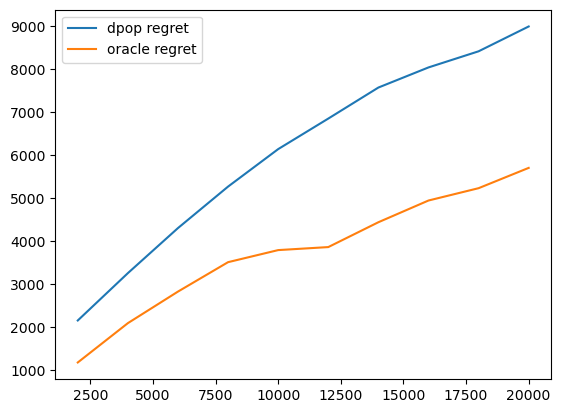

In [11]:
plt.plot(T_horizon_list, dpop_costs - stat_costs, label = 'dpop regret')
plt.plot(T_horizon_list, oracle_costs - stat_costs, label = 'oracle regret')
plt.legend()
plt.savefig('foo1.png', bbox_inches='tight')
plt.show()

In [12]:
# plt.plot(T_horizon_list, dpop_costs - stat_costs, label = 'dpop regret')
# plt.plot(T_horizon_list, dpop_non_null_costs - stat_costs, label = 'actual dpop regret')

# plt.plot(T_horizon_list, oracle_costs - stat_costs, label = 'oracle regret')
# plt.plot(T_horizon_list, oracle_non_null_costs - stat_costs, label = 'actual oracle regret')

# plt.legend()
# plt.show()

[6.52065793e+00 4.26220783e-17 1.79229198e-27]


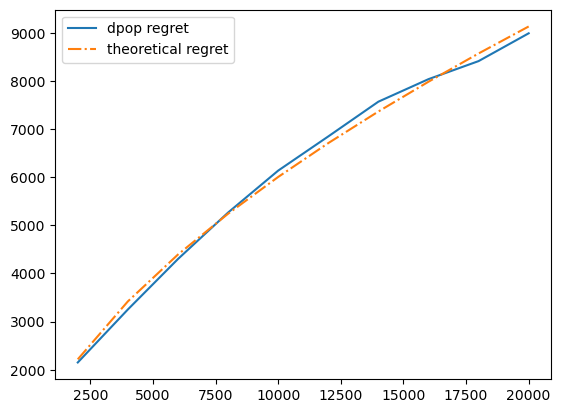

In [13]:
dpop_regret = dpop_costs - stat_costs

X = np.ones([T_horizon_list.shape[0], 3])
X[:,0] = (T_horizon_list**(1/2))*np.log(T_horizon_list)
X[:,1] = T_horizon_list**(2/3) 
# X[:,1] = T_horizon_list**(1/2) 

regret_fit_dpop = lsq_linear(X, dpop_regret, bounds=(0, 100))
theoretical_dpop_regret = X@regret_fit_dpop.x
print(regret_fit_dpop.x)

plt.plot(T_horizon_list, dpop_regret, '-', label = 'dpop regret')
plt.plot(T_horizon_list, theoretical_dpop_regret, '-.', label = 'theoretical regret')
plt.legend()
plt.show()